In [1]:
from ipynb.fs.full.gbs import *

# Experiments

### Experimental Setup

```
                       ┌─────────────┐
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │ Haar-Random │──► [Detector]
[Detector] ◄──[ent]──► │   Unitary   │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
[Detector] ◄──[ent]──► │             │──► [Detector]
                       └─────────────┘
```

### QM Simulation

Let $k$ be the number of entanglement sources. 
Then, the initial state is 
$$2^{-k/2}(|HH\rangle+|VV\rangle)^{\otimes k} = 2^{-k/2}(|1010\rangle+|0101\rangle)^{\otimes k},$$
but reordered so the left (first two) modes of each ent come first, followed by all the right (second two) modes. 
Mathematically, this is 
$$\frac{1}{\sqrt{2^{k}}} \sum_{x \in S} | xx \rangle$$
Where 
$S 
:= \left\{ x \in \{0,1\}^{2k} : \forall i \in \{1, \dots, k\},\ x_{2i-1} \ne x_{2i} \right\} 
= \{01,10\}^{k}$.

We then apply a $2k \times 2k$ Haar-random unitary $U_\text{haar}$ to the right modes by applying the $4k \times 4k$ unitary $U = I \oplus U_\text{haar}$.

Note that there are $2k$ photons in the system, with $k$ of those passing through $U_\text{haar}$, and no mode has more than one photon in it initially.


/home/ronakr/installations/anaconda3/envs/ronakr/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


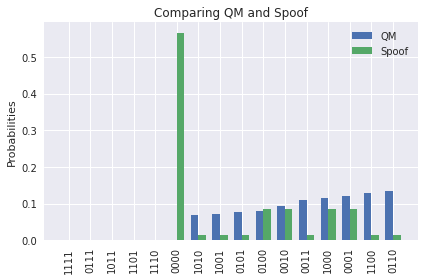

In [2]:
def esthru_no_heralding_or_postselection(num_src, haar_U=None, N=1000):
    '''Entanglement Sources Through Haar-Random Unitary (ESTHRU) experiment.
    Compares probability distributions for QM and Stochastic simulation models.
    Simulates entanglement sources instead of using them for heralding.
    No postselection. '''
    
    m = 4*num_src  # there are 4 modes per entanglement source (rH,rV,lH,lV)
    rm = 2*num_src # two modes exit the right side of each ent (rH,rV)
    n = 2*num_src  # each ent sends one photon out each side

    if not haar_U:
        haar_U = qr_haar(rm)
    if not is_unitary(haar_U):
        raise ValueError('haar_U must be unitary.')
    if haar_U.shape != (rm, rm):
        raise ValueError(f'Unitary must act on {rm} modes.')
        
    #### print(haar_U)

    # Simulate haar_U using QM ("theory")
    # prepare initial state
    basis_states = get_fock_basis_states(n, m)
    non_zero_amp_states = []
    for i in range(2**num_src):
        state = np.zeros(m, dtype=int)
        for digit in range(num_src):
            # each entanglement source either releases H light
            # in both directions or V light in both directions
            ent_index = 2*digit
            h_or_v = (i % 2)
            state[ent_index + h_or_v] = 1
            state[rm + ent_index + h_or_v] = 1
            i >>= 1
        non_zero_amp_states.append(tuple(state))
        
    #### print(non_zero_amp_states)

    initial_state = np.array([(state in non_zero_amp_states) for state in basis_states], dtype=complex) / sqrt(2**num_src)
    #### print('init', initial_state)
    U = direct_sum(np.eye(rm), haar_U) # unitary acting on all modes
    hsu_mat = get_hilbert_space_unitary_matrix(U, n)
    #### print(hsu_mat)
    final_state = hsu_mat @ initial_state
    
    final_probs = conj(final_state) * final_state
    qm_distr = defaultdict(lambda: 0)
    for i,state in enumerate(basis_states):
        detection_event = tuple([(1 if x > 0 else 0) for x in state[rm:]]) 
        qm_distr[detection_event] += final_probs[i]

    # Spoof haar_U using stochastic mechanics ("experiment")
    ents = [ent(N, r=1) for i in range(num_src)]
    l_ents = np.concatenate(tuple([ent[0] for ent in ents]))
    r_ents = np.concatenate(tuple([ent[1] for ent in ents]))
    r_ents = haar_U @ r_ents
    dl = threshold_detector(l_ents)
    dr = threshold_detector(r_ents)
    
    stoch_distr = Counter(map(tuple, dr.T))
    stoch_normalization = N - stoch_distr[tuple(np.zeros(rm))]
    
    distrs_sorted = []
    for det_event in qm_distr:
        distrs_sorted.append((qm_distr[det_event], stoch_distr[det_event]/N, ''.join(map(str,det_event))))
    distrs_sorted = sorted(distrs_sorted)
    
    labels = []
    qm_data = []
    stoch_data = []
    for qm_pt, stoch_pt, det_event in distrs_sorted:
        labels.append(det_event)
        qm_data.append(qm_pt)
        stoch_data.append(stoch_pt)
        
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, qm_data, width, label='QM')
    rects2 = ax.bar(x + width/2, stoch_data, width, label='Spoof')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Probabilities')
    ax.set_title('Comparing QM and Spoof')
    ax.set_xticks(x, labels, rotation=90)
    ax.legend()

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()
    
    # sort by what's heralded
#     counts = defaultdict(lambda: defaultdict(lambda: 0))
#     for i in range(N):
#         counts[tuple(dl[i])][tuple(dr[i])] += 1
    
    #options
    # 1) assume heralded state (eg [0,1,0,1]) is true Fock state (not something indistinguishable like [0,3,0,3])
    # 2) assume true state is (equal?) superposition of all states consistent with heralded state (unconserved photon number means many hsu's)
    # 3) assume true state is (equal?) superposition of all states with num_src photons consistent with heralded state
    
    #QM sim it, turn amps to probs, then graph output pr distr behind stochastic sim raw counts normalized
    
esthru_no_heralding_or_postselection(2, N=1000000)

[(1, 0, 1, 0, 1, 0), (0, 1, 1, 0, 1, 0), (1, 0, 0, 1, 1, 0), (0, 1, 0, 1, 1, 0), (1, 0, 1, 0, 0, 1), (0, 1, 1, 0, 0, 1), (1, 0, 0, 1, 0, 1), (0, 1, 0, 1, 0, 1)]


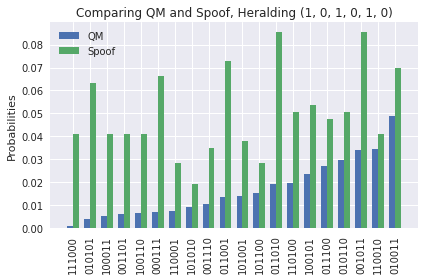

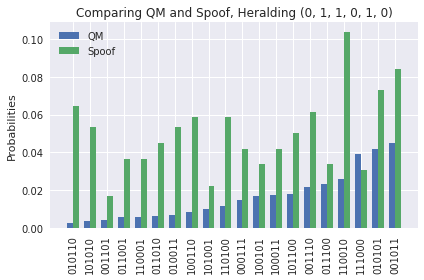

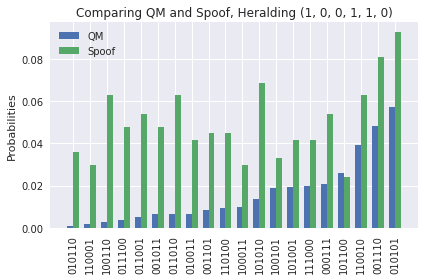

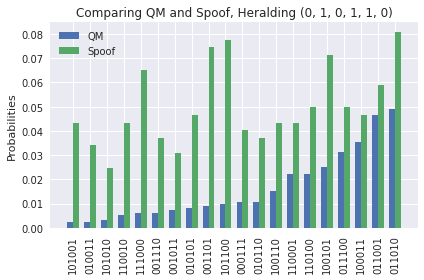

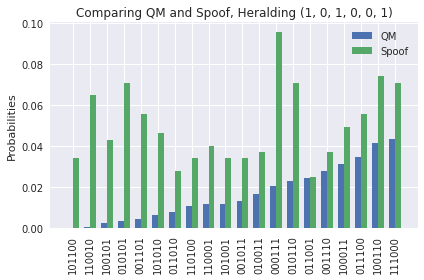

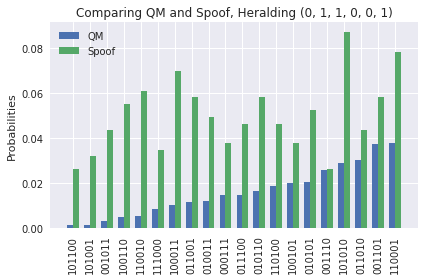

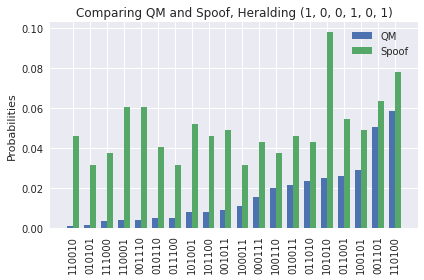

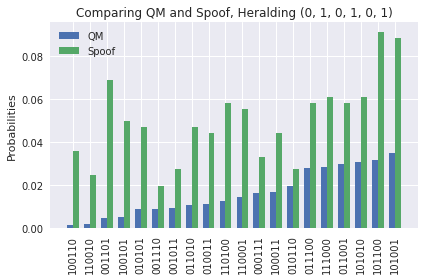

In [3]:
def estu(num_src, U=None, N=1000):
    '''Entanglement Sources Through Unitary (ESTU) experiment.
    Defaults to applying Haar-Random Unitary.
    Compares probability distributions for QM and Stochastic simulation models.
    Uses heralding and postselection. '''
    
    m = 2*num_src   # two modes exit the right side of each ent (rH,rV)
    n = num_src     # each ent sends one photon to the right

    if not U:
        U = qr_haar(m)
    if not is_unitary(U):
        raise ValueError('U must be unitary.')
    if U.shape != (m, m):
        raise ValueError(f'Unitary must act on {m} modes.')
        
    possible_heralds = []
    for i in range(2**n):
        state = [0]*m
        for digit in range(n):
            # each entanglement source either releases H light
            # in both directions or V light in both directions
            ent_index = 2*digit
            h_or_v = (i % 2)
            state[ent_index + h_or_v] = 1
            i >>= 1
        possible_heralds.append(tuple(state))
    print(possible_heralds)
        
    postselection = get_antibunching_states(n, m)
    
    ###########################################
    ### Simulate haar_U using QM ("theory") ###
    ###########################################

    hsu = HilbertSpaceUnitary(U, n, postselection)
    
    qm_distrs = defaultdict(lambda: defaultdict(lambda: 0))
    
    for initial_state in possible_heralds:
        final_state = hsu.apply(initial_state)
        for measurement_outcome in final_state:
            amp = final_state[measurement_outcome]
            probability = amp * conj(amp)
            qm_distrs[initial_state][measurement_outcome] += probability

    #########################################################
    ### Spoof U using stochastic mechanics ("experiment") ###
    #########################################################
    
    ents = [ent(N, r=1) for i in range(num_src)]
    l_ents = np.concatenate(tuple([ent[0] for ent in ents]))
    r_ents = np.concatenate(tuple([ent[1] for ent in ents]))
    r_ents = U @ r_ents
    dl = threshold_detector(l_ents)
    dr = threshold_detector(r_ents)
    
    stoch_distrs = defaultdict(lambda: defaultdict(lambda: 0))
    
    for herald in possible_heralds:
        herald_mask = trials_with_outcome(herald, dl)
        counts = Counter(map(tuple, dr.T[herald_mask]))
        stoch_normalization = 0
        for outcome in postselection:
            stoch_distrs[herald][outcome] = counts[outcome]
            stoch_normalization += counts[outcome]
        if stoch_normalization != 0:
            for outcome in stoch_distrs[herald]:
                stoch_distrs[herald][outcome] /= stoch_normalization
    
    #####################
    ### Graph results ###
    #####################
    
    for herald in possible_heralds:
        distrs_sorted = []
        for det_event in postselection:
            distrs_sorted.append(
                (qm_distrs[herald][det_event], 
                 stoch_distrs[herald][det_event], 
                 ''.join(map(str,det_event)))
            )
        distrs_sorted = sorted(distrs_sorted)
    
        labels = []
        qm_data = []
        stoch_data = []
        for qm_pt, stoch_pt, det_event in distrs_sorted:
            labels.append(det_event)
            qm_data.append(qm_pt)
            stoch_data.append(stoch_pt)

        x = np.arange(len(labels))  # the label locations
        width = 0.35  # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, qm_data, width, label='QM')
        rects2 = ax.bar(x + width/2, stoch_data, width, label='Spoof')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Probabilities')
        ax.set_title(f'Comparing QM and Spoof, Heralding {herald}')
        ax.set_xticks(x, labels, rotation=90)
        ax.legend()

        #ax.bar_label(rects1, padding=3)
        #ax.bar_label(rects2, padding=3)

        fig.tight_layout()

        plt.show()
    
    return qm_distrs, stoch_distrs
    
qm_distrs, stoch_distrs = estu(3, N=1000000)